# Covariance matrix change-point detection under graph stationarity assumption


## Problem formulation

Let $y = (y_1, \ldots, y_t, \ldots, y_T), y_t \in \mathbb{R}^{N}$ a graph signal lying on the nodes of the graph $G = (V, E, W)$, with $N =|V|$.

We aim at detecting changes of the (spatial) covariance matrix $\Sigma_t$ of the graph signals $y_t$. We assume that there exits an unknown set of change-points $\Tau = (t_1, \ldots, t_K) \subset [1, T]$ with unknown cardinality such that the covariance matrix of the graph signals is constant over any segment $[t_k, t_{k+1}]$. We do the following hypothesis:

1. the signals $y_t$ follow a multivariate Gaussian distribution with fixed covariance matrix over each segment and known mean $\mu$, i.e:
$$\forall k \in [1, K] ~ \forall t \in [t_k, t_{k+1}] \quad y_t \sim \mathcal{N}(\mu, \Sigma_k)$$

2. over each segment, the signals $y_t$ verify the second order wide-sense graph stationarity:
$$\forall k \in [1, K] \quad \Sigma_k = U \text{diag}(\gamma_k)U^T $$

where the matrix $U$ contains the eigenvectors of the graph combinatorial Laplacian matrix $L = D - W$ in its columns. 

The Graph Fourier Transform $\tilde{y}$ of a signal $y$ is defined by $\tilde{y} = U^T y $.


Based on the above assumptions, the cost derived from the maximum log-likelihood over a segment $[a, b-1]$ writes:

\begin{align*}
    c_s(y_{a}, \ldots, y_{b-1}) = ~ & (b - a) \sum_{n=1}^N \log \hat{\gamma}_{a.b}^{(n)} ~ + ~ \sum_{t=a}^{b-1} \sum_{n=1}^N \frac{\left(\tilde{y}_t^{(n)} - \hat{\tilde{\mu}}_T^{(n)}\right)^2}{\hat{\gamma}_{a.b}^{(n)}} = ~ (b - a) \sum_{n=1}^N \log \hat{\gamma}_{a.b}^{(n)} ~ + N(b-a)
\end{align*}

where:

- $\hat{\mu}_{T}$ is the empirical mean of the process over $[0, T]$
- $\hat{\gamma}_{a..b}$ is the (empirical) biased correlogram/periodogram of the process over $[a, b-1]$: $\hat{\gamma}_{a..b} = \frac{1}{(b-a)} \sum_{t=a}^{b-1} \left(\tilde{y}_t^{(n)} - \hat{\tilde{\mu}}_T^{(n)}\right)^2$

### Computation of the cost

In [25]:
import numpy as np

from scipy.linalg import eigh
from ruptures.base import BaseCost

class CostGraphStatioNormal(BaseCost):

    """
    """

    model = "graph_sationary_normal_cost"

    def __init__(self, laplacian_mat) -> None:
        """
        Args:
            laplacian_mat (array): the discrete Laplacian matrix of the graph: D - W
            where D is the diagonal matrix diag(d_i) of the node degrees and W the adjacency matrix
        """
        self.graph_laplacian_mat = laplacian_mat
        self.signal = None
        self.gft_square_cumsum = None
        self.gft_mean = None
        self.min_size = laplacian_mat.shape[0]
        super().__init__()
    
    def fit(self, signal):
        """Performs pre-computations for per-segment approximation cost.

        NOTE: the number of dimensions of the signal and their ordering
        must match those of the nodes of the graph.
        The function eigh used below returns the eigenvector corresponding to 
        the ith eigenvalue in the ith column eigvect[:, i]

        Args:
            signal (array): of shape [n_samples, n_dim].
        """
        self.signal = signal
        # Computation of the GFSS
        _, eigvects = eigh(self.graph_laplacian_mat)
        gft =  signal @ eigvects # equals signal.dot(eigvects) = eigvects.T.dot(signal.T).T
        self.gft_mean = np.mean(gft, axis=0)
        # Computation of the per-segment cost utils
        self.gft_square_cumsum = np.concatenate([np.zeros((1, signal.shape[1])), np.cumsum((gft - self.gft_mean[None, :])**2, axis=0)], axis=0)
        return self

    def error(self, start, end):
        """

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            float: segment cost
        """
        if end - start < self.min_size:
            raise ValueError(f'end - start shoud be higher than {self.min_size}')
        sub_square_sum = self.gft_square_cumsum[end] - self.gft_square_cumsum[start]
        return (end  - start) * np.sum(np.log(sub_square_sum / (end - start)))


## Experiments: synthetic data

### Observation on the minimum distance between consecutive change points

We require that the different change points $(t_1, \ldots, t_K)$ verify:

$$|t_{k+1} - t_k| >= l ~ \forall k \in [1, K-1] $$

where $l$ can be seen as the minimum segment length. In this paragraph we give a meaningful lower bound of this parameter. Such lower bound is related to the computation of the cost functions over the segments $[a, b] \subset [0, T]$, namely the graph stationary normal cost function $c_s$ described above and the standard normal cost function $c_n$:

- $ c_n(y_{a}, \ldots, y_{b-1}) = (b - a) \log  \left[ \det \left( \hat \Sigma_{a..b} \right) \right]$
- $ c_s(y_{a}, \ldots, y_{b-1}) = (b - a) \sum_{n=1}^N \log \hat{\gamma}_{a.b}^{(n)} $

Based on the formula of the spectrogram $\hat{\gamma}_{a.b}$ given in the introduction, there is no numerical constraints for the feasibility of the computation. However, the $\log [ \det ( \cdot ) ]$ function used in the formula for $c_n$ should be applied to invertible matrices $\Sigma_{a..b}$ only. Therefore, we should focus on the conditions under which the matrix:

$$ \hat \Sigma_{a..b} = \frac{1}{b-a} \sum_{t=a}^{b-1} (y_t - \mu_T) (y_t - \mu_T)^T \quad \text{ with } y_t \sim \mathcal{N}(\mu, \Sigma)  $$

is invertible. Actually, such conditions have already been clearly stated in different works from Random Matrix Theory (RMT). For instance, it is shown in [[Izenman2008](#Izenman2008)] that $n \hat \Sigma_{a..b} \sim \mathcal{W}(b-a, \Sigma)$ follows the Wishart distribution. In this framework, it is possible to study the distribution of the eigenvalues of $\hat \Sigma_{a..b}$ and to deduce that: 

$$ \text{If } b-a > N \text{ with } N  \text{ the dimension of } y_t, \text{ then } \hat \Sigma_{a..b} \text{ is almost surely invertible }   $$

Conversely, it is possible to show that if $ b-a < N $ (the number of observations is lower then the number of variables), the matrix $\hat \Sigma_{a..b}$ is nalmost surely not invertible. This can be done by considering the family the first $(N+1)$ columns of $\hat \Sigma_{a..b}$.

Thus, the right lower-bound $l$ should be $\boxed{l = N}$, which is consistent with statement from [[Ryan2023](#Ryan2023)].

Note: with segments of length $l$, one is not guaranteed to compute good estimates of the covariance matrix, but at least such computations is almost surely admissible.

### Utils and visualization

In [26]:
import time
import subprocess
import json
import os
import warnings

import networkx as nx
import ruptures as rpt
import matplotlib.pyplot as plt

from datetime import datetime
from pathlib import Path
from tqdm import tqdm
from typing import List
from typing import Literal

#### Miscellaneous

In [27]:
def get_git_head_short_hash() -> str:
    return subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).decode('ascii').strip()

In [28]:
def turn_all_list_of_dict_into_str(data:dict):
    new_dict = {}
    for key, val in data.items():
        if isinstance(val, list):
            new_dict[key] = str(val)
        elif isinstance(val, dict):
            new_dict[key] = turn_all_list_of_dict_into_str(val)
        else:
            new_dict[key] = val
    return new_dict

In [29]:
def turn_str_of_list_into_list_of_int(list_str):
    assert list_str[0] == '[' and list_str[-1] == ']'
    list_of_str = list_str[1:-1].split(',')
    return [int(val_str) for val_str in list_of_str]

In [30]:
def create_parent_and_dump_json(parent_dir, name, data, indent=None):
    if not os.path.exists(parent_dir):
        Path(parent_dir).mkdir(parents=True, exist_ok=False)
    with open(os.path.join(parent_dir, name), 'w+') as f:
        json.dump(data, f, indent=indent)

In [31]:
def open_json(path):
    with open(path, 'r+') as f:
        content = json.load(f)
    return content

#### Data generation

In [32]:
def generate_random_er_graphs(params_rng, nx_graph_seed, min_n_nodes=10, max_n_nodes=30, min_edge_p=0.15, max_edge_p=0.5):
    n_nodes = params_rng.integers(low=min_n_nodes, high=max_n_nodes+1)
    edge_p = min_edge_p + (max_edge_p-min_edge_p) * params_rng.random()
    G = nx.erdos_renyi_graph(n=n_nodes, p=edge_p, seed=nx_graph_seed)
    return G

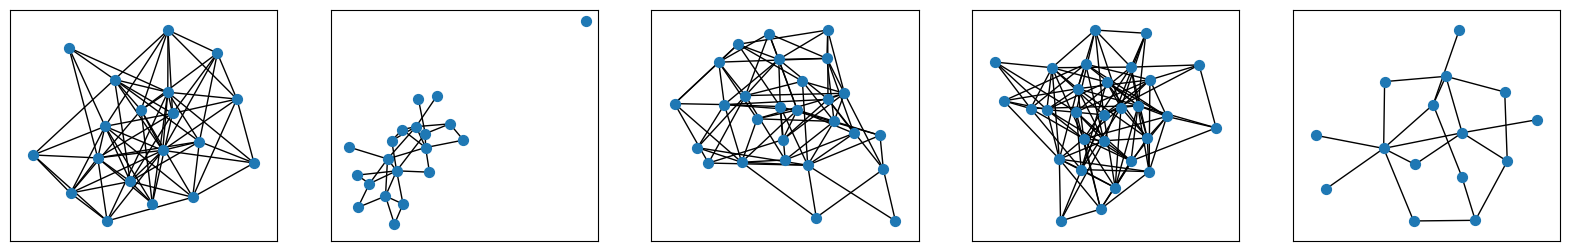

In [33]:
graph_seed = 0
params_seed = 1
fig, axes = plt.subplots(1, 5, figsize=(4*5, 3))
params_rng = np.random.default_rng(seed=params_seed)
for _ in range(5):
    G = generate_random_er_graphs(params_rng, graph_seed)
    coord = nx.spring_layout(G, seed=0)
    nx.draw_networkx(G, with_labels=False, pos=coord, node_size=50, ax=axes[_])

In [34]:
def generate_gaus_signal_with_cov_diag_in_basis(n_dims, n_samples, eigvects, signal_rng, diag_cov_max=1):
    # randomly draw diagonal coef (in the fourier space)
    diag_coefs = diag_cov_max * signal_rng.random(n_dims)
    diag_mat = np.diag(diag_coefs)
    # compute the corresponding covariance matrix and signal 
    cov_mat = eigvects @ diag_mat @ eigvects.T
    signal = signal_rng.multivariate_normal(np.zeros(n_dims), cov_mat, size=n_samples)
    return signal

In [35]:
seg_length = Literal["large", "minimal"]

def get_min_size_for_hyp(n_dims, hyp:seg_length = "minimal"):
    # the minimal segment length for admissible computations
    min_size = n_dims
    if hyp == "large":
        #for segment long enough for good estimates
        min_size = n_dims * (n_dims-1) / 2
    return min_size

In [36]:
def draw_bkps_with_gap_constraint(n_samples, bkps_gap, bkps_rng, n_bkps_max, max_tries=10000):
    # randomly pick an admissible number of bkps
    n_bkps = bkps_rng.integers(low=1, high=min(n_bkps_max, n_samples // bkps_gap))
    bkps = []
    n_tries = 0
    # select admissible randomly drawn bkps
    while n_tries < max_tries and len(bkps) < n_bkps:
        new_bkp = bkps_rng.integers(low=bkps_gap, high=n_samples-bkps_gap)
        to_keep = True
        for bkp in bkps:
            if abs(new_bkp - bkp) < bkps_gap:
                to_keep = False
                break
        if to_keep:
            bkps.append(new_bkp)
        n_tries+=1
    bkps.sort()
    return bkps + [n_samples]

#### Data writting and reading

In [37]:
def save_data(G:nx.Graph, signal:np.ndarray, bkps:List[int], dir:str):
    # create subfolder
    Path(dir).mkdir(parents=True, exist_ok=False)
    # save graph
    nx.write_adjlist(G, f'{dir}/graph.adjlist')
    # save signal
    with open(f'{dir}/signal.npy', 'wb+') as np_f:
        np.save(np_f, signal, allow_pickle=False)
    # save bkps
    bkps_str = [int(bkp) for bkp in bkps]
    create_parent_and_dump_json(dir, "bkps.json", bkps_str)

In [38]:
def read_data(path: str):
    G = nx.read_adjlist(f"{path}/graph.adjlist")
    signal = np.load(f"{path}/signal.npy", allow_pickle=False)
    bkps = open_json(f"{path}/bkps.json")
    return G, signal, bkps

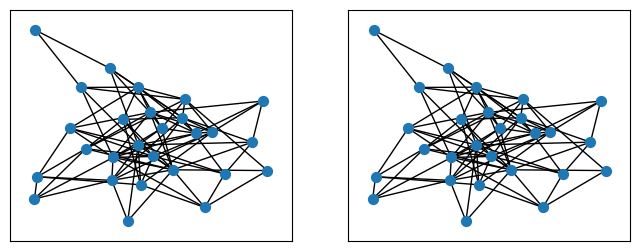

In [39]:
# Creation of a random graph
nx_graph_seed = 2
graph_seed = 2
graph_rng = np.random.default_rng(seed=graph_seed)
G = generate_random_er_graphs(graph_rng, nx_graph_seed)

# Writting and reading of the graph
nx.write_adjlist(G, "data/synthetic_data/test/test.adjlist")
G2 = nx.read_adjlist("data/synthetic_data/test/test.adjlist")

# Plotting the two graphs, using the same coord to check if no re-labelling happen
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
coord = nx.spring_layout(G, seed=0)
coord2 = {str(key): val for key, val in coord.items()}
nx.draw_networkx(G, with_labels=False, pos=coord, node_size=50, ax=axes[0])
nx.draw_networkx(G2, with_labels=False, pos=coord2, node_size=50, ax=axes[1])

#### Results computation and saving

In [40]:
from ruptures.metrics import precision_recall
from ruptures.metrics import hausdorff

def update_metrics(true_bkps, pred_bkps, metrics_dic, prec_rec_margin):
    preci, recall = precision_recall(true_bkps, pred_bkps, prec_rec_margin)
    hsdrf = hausdorff(true_bkps, pred_bkps)
    metrics_dic["precision"]['raw'].append(round(preci, 4))
    metrics_dic["recall"]['raw'].append(round(recall, 4))
    metrics_dic["hausdorff"]['raw'].append(hsdrf)

In [41]:
def compute_and_add_stat_on_metrics(model_metrics:dict):
    for model_res in model_metrics.values():
        for metric_name, res in model_res.items():
            model_res[metric_name]['mean'] = round(np.mean(res['raw']), ndigits=4)
            model_res[metric_name]['std'] = round(np.std(res['raw']), ndigits=4)
    return model_metrics

In [42]:
def save_metrics(metrics_per_models, stats, dir, comment=''):
    now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    to_save = {"date_time": now, 'comment': comment}
    to_save["hyper-parameters"] = stats
    to_save["results"] = metrics_per_models
    to_save = turn_all_list_of_dict_into_str(to_save)
    create_parent_and_dump_json(dir, now + '.json', to_save, indent=4)

### A. Data verifying the hypothesis of the model

In this experiment, we generate data according to the hypothesis presented in the [problem formulation](#problem-formulation) and we compare our method to the cost function for standard covariance change detection in Gaussian models (that is supposed to cover our hypothesis). More precisely, we randomly generate a graph and a corresponding multivariate Gaussian signal, undergoing a (known) random number of covariance change points. The comparison between the two methods relies on the precision / recall and Hausdorff metrics.

In [43]:
def generate_rd_signal_in_hyp(G:nx.Graph, signal_rng:np.random.Generator,  n_bkps_max, hyp:seg_length="minimal", n_samples:int=500, diag_cov_max=1):
    # randomly draw a set of admissible change points
    n_dims = G.number_of_nodes()
    min_size = get_min_size_for_hyp(n_dims=n_dims, hyp=hyp)
    bkps = draw_bkps_with_gap_constraint(n_samples, min_size, signal_rng, n_bkps_max)
    # generate the signal
    _, eigvects = eigh(nx.laplacian_matrix(G).toarray())
    signal_gen_func = lambda size: generate_gaus_signal_with_cov_diag_in_basis(n_dims, size, eigvects, signal_rng, diag_cov_max)
    signal = signal_gen_func(bkps[0])
    # add each sub-segment
    for i in range(1, len(bkps)):
        sub_signal = signal_gen_func(bkps[i] - bkps[i-1])
        signal = np.concatenate([signal, sub_signal], axis=0)
    return bkps, signal

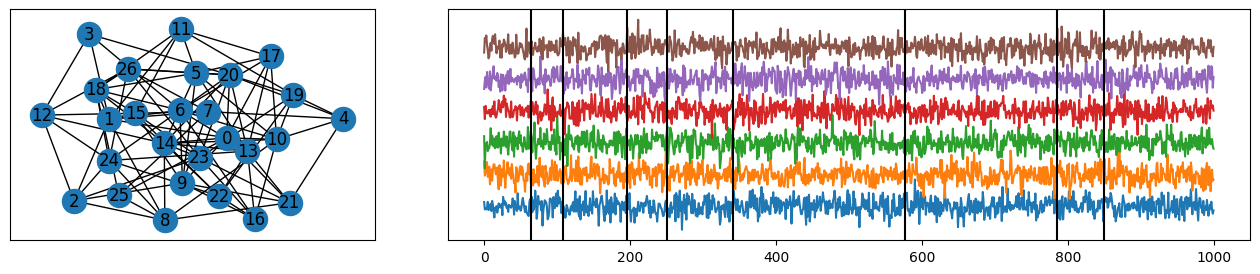

In [44]:
nx_graph_seed = 1
graph_seed = 2
signal_seed = 3

signal_rng = np.random.default_rng(seed=signal_seed)
graph_rng = np.random.default_rng(seed=graph_seed)

G = generate_random_er_graphs(graph_rng, nx_graph_seed)
bkps, s = generate_rd_signal_in_hyp(G, signal_rng, n_samples=1000, diag_cov_max=10, n_bkps_max=10)

fig, axes = plt.subplot_mosaic(mosaic='ABB', figsize=(16, 3))
nx.draw_networkx(G, ax=axes['A'])
for i in range(6):
    axes['B'].plot(10*i+s[:, i])
axes['B'].set_yticks([])
for bkp in bkps[:-1]:
    axes['B'].axvline(x=bkp, c='k')

In [45]:
N_EXP1 = 5
NX_GRAPH_SEED = 1
GRAPH_SEED = 2
SIGNAL_SEED = 3
MAX_N_NODES = 25
N_SAMPLES = 1000
MAX_N_BKPS = 10
BKPS_GAP_CONSTRAINT: seg_length = "large" 

# initialization
data_dir_1 = "data/synthetic_data/exp_A_within_hypothesis/A_1/" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
signal_rng = np.random.default_rng(seed=SIGNAL_SEED)
graph_rng = np.random.default_rng(seed=GRAPH_SEED)
desc = ['Large gap constraint, to reproduce TEST.json', 'Data verifying the two hypothesis', 'Purpose: sanity-check when data fits into the model.']
data_metadata_1 = {"description": desc, "commit hash":get_git_head_short_hash(), "graph_func": generate_random_er_graphs.__name__, "signal_func": generate_rd_signal_in_hyp.__name__, "n_iter": N_EXP1, "graph_seed": GRAPH_SEED, "nx_graph_seed": NX_GRAPH_SEED, "signal_seed": SIGNAL_SEED, "n_samples": N_SAMPLES, "max_n_nodes": MAX_N_NODES, "max_n_bkps": MAX_N_BKPS, "bkps_gap_hyp": BKPS_GAP_CONSTRAINT, "n_nodes": []}

# # data generation and saving
for exp_id in range(N_EXP1):
    subdir = f"{data_dir_1}/{exp_id}"
    G = generate_random_er_graphs(graph_rng, NX_GRAPH_SEED, max_n_nodes=MAX_N_NODES)
    data_metadata_1["n_nodes"].append(int(G.number_of_nodes()))
    gt_bkps, signal = generate_rd_signal_in_hyp(G, signal_rng, n_samples=N_SAMPLES, hyp=BKPS_GAP_CONSTRAINT, n_bkps_max=MAX_N_BKPS)
    save_data(G, signal, gt_bkps, subdir)

# storing metadata
data_metadata_1 = turn_all_list_of_dict_into_str(data_metadata_1)
create_parent_and_dump_json(data_dir_1, "metadata.json", data_metadata_1, indent=4)

In [46]:
# initialization
date = "2024-06-18_16-51-20"
data_dir_1 = "data/synthetic_data/exp_A_within_hypothesis/A_1/" + date
data_stats = open_json(f"{data_dir_1}/metadata.json")
data_stats["bkps"] = {}
data_stats["data_path"] = data_dir_1

# output formatting
results_dir_1 = "results/synthetic/A_within_hypothesis/A1/" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
statio_results_1 = {}
normal_results_1 = {}

subfold_list = [subdir for subdir in os.listdir(data_dir_1) if '.' not in subdir]
for exp_id in tqdm(subfold_list, desc='Running experiment...'):

    # loading data
    subdir = f"{data_dir_1}/{exp_id}"
    G, signal, gt_bkps = read_data(subdir)
    min_size = get_min_size_for_hyp(G.number_of_nodes(), hyp=data_stats["bkps_gap_hyp"])
    data_stats["bkps"][exp_id] = gt_bkps

    # prediction with standard normal cost
    t1 = time.perf_counter()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        normal_cost = rpt.costs.CostNormal()
        algo_normal = rpt.Dynp(custom_cost=normal_cost, jump=1, min_size=min_size).fit(signal)
        normal_bkps = algo_normal.predict(n_bkps=len(gt_bkps)-1)
    t2 = time.perf_counter()
    normal_results_1[exp_id] = {}
    normal_results_1[exp_id]["time"] = round(t2 - t1, ndigits=3)
    normal_results_1[exp_id]["pred"] = normal_bkps

    # prediction with stationary normal cost
    t1 = time.perf_counter()
    statio_cost = CostGraphStatioNormal(nx.laplacian_matrix(G).toarray())
    algo_statio = rpt.Dynp(custom_cost=statio_cost, jump=1, min_size=min_size).fit(signal)
    statio_bkps = algo_statio.predict(n_bkps=len(gt_bkps)-1)
    t2 = time.perf_counter()
    statio_results_1[exp_id] = {}
    statio_results_1[exp_id]["time"] = round(t2 - t1, ndigits=3)
    statio_results_1[exp_id]["pred"] = statio_bkps

# storing
create_parent_and_dump_json(results_dir_1, "data_stats.json", turn_all_list_of_dict_into_str(data_stats), indent=4)
create_parent_and_dump_json(results_dir_1, "statio_pred.json", turn_all_list_of_dict_into_str(statio_results_1), indent=4)
create_parent_and_dump_json(results_dir_1, "normal_pred.json", turn_all_list_of_dict_into_str(normal_results_1), indent=4)


Running experiment...: 100%|██████████| 5/5 [00:32<00:00,  6.45s/it]


In [23]:
PRECI_RECALL_MARGIN = 2

# initialization
pred_dir_1 = results_dir_1
data_stats = open_json(f"{results_dir_1}/data_stats.json")
statio_pred_1 = open_json(f"{results_dir_1}/statio_pred.json")
normal_pred_1 = open_json(f"{results_dir_1}/normal_pred.json")
gt_bkps_dic = data_stats.pop('bkps')

# output formatting
metrics_dic_1 = {}
metrics_dic_1["pred_path"] = results_dir_1
metrics_dic_1["hyper-parameters"] = data_stats
metrics_dic_1["hyper-parameters"]["metrics_margin"] = PRECI_RECALL_MARGIN

statio_results_1 = {"recall": {'raw': []}, "precision": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}
normal_results_1 = {"recall": {'raw': []}, "precision": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}

for exp_id in gt_bkps_dic.keys():
    # compute metrics
    normal_pred = turn_str_of_list_into_list_of_int(normal_pred_1[exp_id]["pred"])
    statio_pred = turn_str_of_list_into_list_of_int(statio_pred_1[exp_id]["pred"])
    update_metrics(gt_bkps_dic[exp_id], normal_pred, normal_results_1, PRECI_RECALL_MARGIN)
    update_metrics(gt_bkps_dic[exp_id], statio_pred, statio_results_1, PRECI_RECALL_MARGIN)
    # add time values
    normal_results_1["time"]["raw"].append(normal_pred_1[exp_id]["time"])
    statio_results_1["time"]["raw"].append(statio_pred_1[exp_id]["time"])

# results post-precessing and saving
full_results_1 = {"statio normal cost": statio_results_1, "normal cost": normal_results_1}
full_results_1 = compute_and_add_stat_on_metrics(full_results_1)
create_parent_and_dump_json(pred_dir_1, 'metrics', full_results_1, indent=4)

BadPartitions: The end of the last regime is not the same for each of the partitions:
[295, 648]
[295, 648]

In [ ]:
N_EXP1 = 50
NX_GRAPH_SEED = 1
GRAPH_SEED = 2
SIGNAL_SEED = 3
PRECI_RECALL_MARGIN = 2
MAX_N_NODES = 25
N_SAMPLES = 1000
MAX_N_BKPS = 10

signal_rng = np.random.default_rng(seed=SIGNAL_SEED)
graph_rng = np.random.default_rng(seed=GRAPH_SEED)

# initialization
exp_statistics_1 = {"commit hash":get_git_head_short_hash(), "n_iter": N_EXP1, "graph_seed": GRAPH_SEED, "nx_graph_seed": NX_GRAPH_SEED, "signal_seed": SIGNAL_SEED, "metrics_margin": PRECI_RECALL_MARGIN, "n_samples": N_SAMPLES, "max_n_nodes": MAX_N_NODES, "max_n_bkps": MAX_N_BKPS, "n_nodes": [], "bkps":[]}
statio_results_1 = {"recall": {'raw': []}, "precision": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}
normal_results_1 = {"recall": {'raw': []}, "precision": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}

for exp_id in tqdm(range(N_EXP1), desc='Running experiment'):
    
    # data and ground truth generation
    G = generate_random_er_graphs(graph_rng, NX_GRAPH_SEED, max_n_nodes=MAX_N_NODES)
    gt_bkps, signal = generate_rd_signal_in_hyp(G, signal_rng, n_samples=N_SAMPLES, n_bkps_max=MAX_N_BKPS)
    min_size = get_min_size_for_hyp(G.number_of_nodes())

    # prediction with standard normal cost
    t1 = time.perf_counter()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        normal_cost = rpt.costs.CostNormal()
        algo_normal = rpt.Dynp(custom_cost=normal_cost, jump=1, min_size=min_size).fit(signal)
        normal_bkps = algo_normal.predict(n_bkps=len(gt_bkps)-1)
    t2 = time.perf_counter()
    normal_results_1["time"]['raw'].append(round(t2 - t1, ndigits=3))

    # prediction with stationary normal cost
    t1 = time.perf_counter()
    statio_cost = CostGraphStatioNormal(nx.laplacian_matrix(G).toarray())
    algo_statio = rpt.Dynp(custom_cost=statio_cost, jump=1, min_size=min_size).fit(signal)
    statio_bkps = algo_statio.predict(n_bkps=len(gt_bkps)-1)
    t2 = time.perf_counter()
    statio_results_1["time"]['raw'].append(round(t2 - t1, ndigits=3))

    # performances evaluation
    update_metrics(gt_bkps, normal_bkps, normal_results_1, PRECI_RECALL_MARGIN)
    update_metrics(gt_bkps, statio_bkps, statio_results_1, PRECI_RECALL_MARGIN)

    # statistics collection
    exp_statistics_1["bkps"].append((len(gt_bkps)-1, gt_bkps[:-1]))
    exp_statistics_1["n_nodes"].append(G.number_of_nodes())

# results post-precessing and saving
full_results_1 = {"statio normal cost": statio_results_1, "normal cost": normal_results_1}
full_results_1 = compute_and_add_stat_on_metrics(full_results_1)
save_metrics(full_results_1, exp_statistics_1, 'results/within_hypothesis', comment='1. bkps drawn with minimal gap constraints')

In [ ]:
print("STATISTICS:\t", exp_statistics_1)
print("WITH STATIO:\t", statio_results_1)
print("WITHOUT STATIO:\t", normal_results_1)

### B. Data not verifying the hypothesis of the model

In what follows, we work with signals verifying hypothesis 1 from the [the problem formulation](#problem-formulation), but not respecting the second hypothesis. More precisely, we will generate covariance matrices that are diagonalizable in a basis different from the Fourier one.

In [ ]:
def generate_rd_signal_from_other_basis(G:nx.Graph, signal_rng:np.random.Generator, n_samples:int=500, diag_cov_max=1, n_bkps_max=10):
    # randomly draw a set of admissible change points
    n_dims = G.number_of_nodes()
    min_size = get_min_size_for_hyp(n_dims=n_dims)
    bkps = draw_bkps_with_gap_constraint(n_samples, min_size, signal_rng, n_bkps_max)
    # generate another graph to compute the signal covariance matrices
    G_for_cov = generate_random_er_graphs(signal_rng, NX_GRAPH_SEED, n_dims, n_dims, min_edge_p=0.01, max_edge_p=1)
    _, eigvects = eigh(nx.laplacian_matrix(G_for_cov).toarray())
    signal_gen_func = lambda size: generate_gaus_signal_with_cov_diag_in_basis(n_dims, size, eigvects, signal_rng, diag_cov_max)
    signal = signal_gen_func(bkps[0])
    # add each sub-segment
    for i in range(1, len(bkps)):
        sub_signal = signal_gen_func(bkps[i] - bkps[i-1])
        signal = np.concatenate([signal, sub_signal], axis=0)
    return bkps, signal

In [ ]:
N_EXP2 = 50

signal_rng = np.random.default_rng(seed=SIGNAL_SEED)
graph_rng = np.random.default_rng(seed=GRAPH_SEED)

# initialization
exp_statistics_2 = {"commit hash":get_git_head_short_hash(), "n_iter": N_EXP2, "graph_seed": GRAPH_SEED, "nx_graph_seed": NX_GRAPH_SEED, "signal_seed": SIGNAL_SEED, "metrics_margin": PRECI_RECALL_MARGIN, "n_samples": N_SAMPLES, "max_n_nodes": MAX_N_NODES, "max_n_bkps": MAX_N_BKPS, "n_nodes": [], "bkps":[]}
statio_results_2 = {"recall": {'raw': []}, "precision": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}
normal_results_2 = {"recall": {'raw': []}, "precision": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}

for exp_id in tqdm(range(N_EXP2), desc='Running experiment'):
    
    # data and ground truth generation
    G = generate_random_er_graphs(graph_rng, NX_GRAPH_SEED, max_n_nodes=MAX_N_NODES)
    gt_bkps, signal = generate_rd_signal_from_other_basis(G, signal_rng, n_samples=N_SAMPLES, n_bkps_max=MAX_N_BKPS)
    min_size = get_min_size_for_hyp(G.number_of_nodes())

    # prediction with standard normal cost
    t1 = time.perf_counter()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        normal_cost = rpt.costs.CostNormal()
        algo_normal = rpt.Dynp(custom_cost=normal_cost, jump=1, min_size=min_size).fit(signal)
        normal_bkps = algo_normal.predict(n_bkps=len(gt_bkps)-1)
    t2 = time.perf_counter()
    normal_results_2["time"]['raw'].append(round(t2 - t1, ndigits=3))

    # prediction with stationary normal cost
    t1 = time.perf_counter()
    statio_cost = CostGraphStatioNormal(nx.laplacian_matrix(G).toarray())
    algo_statio = rpt.Dynp(custom_cost=statio_cost, jump=1, min_size=min_size).fit(signal)
    statio_bkps = algo_statio.predict(n_bkps=len(gt_bkps)-1)
    t2 = time.perf_counter()
    statio_results_2["time"]['raw'].append(round(t2 - t1, ndigits=3))

    # performances evaluation
    update_metrics(gt_bkps, normal_bkps, normal_results_2, PRECI_RECALL_MARGIN)
    update_metrics(gt_bkps, statio_bkps, statio_results_2, PRECI_RECALL_MARGIN)

    # statistics collection
    exp_statistics_2["bkps"].append((len(gt_bkps)-1, gt_bkps[:-1]))
    exp_statistics_2["n_nodes"].append(G.number_of_nodes())

# results post-precessing and saving
full_results_2 = {"statio normal cost": statio_results_2, "normal cost": normal_results_2}
full_results_2 = compute_and_add_stat_on_metrics(full_results_2)
save_metrics(full_results_2, exp_statistics_2, 'results/out_of_hypothesis', comment='1. the covariance matrix is diagonal in the Fourier basis of another random Erdos-Renyi graphs \n2. bkps drawn with  bkps drawn with minimal gap constraints')

In [ ]:
print("STATISTICS:\t", exp_statistics_2)
print("WITH STATIO:\t", statio_results_2)
print("WITHOUT STATIO:\t", normal_results_2)

### C. Data verifying the hypothesis of the models, with node dropping to simulate breakdowns

In what follows, we work with signals verifying the two hypothesis from the [the problem formulation](#problem-formulation). Additionally, we will randomly select a (very) small number of nodes and simulate the breakdown of the corresponding sensors by setting the value of signal lying on this node to 0 for a random time length.

In [ ]:
def modify_signal_to_simulate_breakdown(signal, signal_rng, n_breakdown_max):
    # initialization
    n_samples = signal.shape[0]
    n_breakdown = signal_rng.integers(1, n_breakdown_max+1)
    # randomly pick the location and time length of the breakdowns
    breakdowns = {}
    broken_node_ids = signal_rng.integers(0, signal.shape[1], size=(n_breakdown))
    for node_id in broken_node_ids:
        start = signal_rng.integers(0, n_samples-1)
        end = signal_rng.integers(start, n_samples)
        signal[start:end, node_id] = 0
        breakdowns[node_id] = (start, end)
    return signal, breakdowns

In [ ]:
nx_graph_seed = 1
graph_seed = 2
signal_seed = 5

signal_rng = np.random.default_rng(seed=signal_seed)
graph_rng = np.random.default_rng(seed=graph_seed)

G = generate_random_er_graphs(graph_rng, nx_graph_seed)
bkps, s = generate_rd_signal_in_hyp(G, signal_rng, n_samples=G.number_of_nodes()**2, diag_cov_max=1)
s, breakdowns = modify_signal_to_simulate_breakdown(s, signal_rng, G.number_of_nodes()//10)

print("The generated breakdowns are:", breakdowns)

fig, ax = plt.subplots(1, 1, figsize=(12,3))
for i in range(5):
    ax.plot(10*i+s[:, i])
for i, node_id in enumerate(breakdowns.keys()):
    ax.plot(10*(i+5)+s[:, node_id])

In [ ]:
N_EXP3 = 50

signal_rng = np.random.default_rng(seed=SIGNAL_SEED)
graph_rng = np.random.default_rng(seed=GRAPH_SEED)

# initialization
exp_statistics_3 = {"commit hash":get_git_head_short_hash(), "n_iter": N_EXP3, "graph_seed": GRAPH_SEED, "nx_graph_seed": NX_GRAPH_SEED, "signal_seed": SIGNAL_SEED, "metrics_margin": PRECI_RECALL_MARGIN, "n_samples": N_SAMPLES, "max_n_nodes": MAX_N_NODES, "max_n_bkps": MAX_N_BKPS, "n_nodes": [], "bkps":[], "breakdowns": []}
statio_results_3 = {"recall": {'raw': []}, "precision": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}
normal_results_3 = {"recall": {'raw': []}, "precision": {'raw': []}, "hausdorff": {'raw': []}, "time": {"raw": []}}

for exp_id in tqdm(range(N_EXP3), desc='Running experiment'):
    
    # data and ground truth generation
    G = generate_random_er_graphs(graph_rng, NX_GRAPH_SEED, max_n_nodes=MAX_N_NODES)
    n_nodes = G.number_of_nodes()
    gt_bkps, signal = generate_rd_signal_in_hyp(G, signal_rng, n_samples=N_SAMPLES, n_bkps_max=MAX_N_BKPS)
    signal, breakdowns = modify_signal_to_simulate_breakdown(signal, signal_rng, n_nodes//10)
    min_size = get_min_size_for_hyp(G.number_of_nodes())

    # prediction with standard normal cost
    t1 = time.perf_counter()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        normal_cost = rpt.costs.CostNormal()
        algo_normal = rpt.Dynp(custom_cost=normal_cost, jump=1, min_size=min_size).fit(signal)
        normal_bkps = algo_normal.predict(n_bkps=len(gt_bkps)-1)
    t2 = time.perf_counter()
    normal_results_3["time"]['raw'].append(round(t2 - t1, ndigits=3))

    # prediction with stationary normal cost
    t1 = time.perf_counter()
    statio_cost = CostGraphStatioNormal(nx.laplacian_matrix(G).toarray())
    algo_statio = rpt.Dynp(custom_cost=statio_cost, jump=1, min_size=min_size).fit(signal)
    statio_bkps = algo_statio.predict(n_bkps=len(gt_bkps)-1)
    t2 = time.perf_counter()
    statio_results_3["time"]['raw'].append(round(t2 - t1, ndigits=3))
    

    # performances evaluation
    update_metrics(gt_bkps, normal_bkps, normal_results_3, PRECI_RECALL_MARGIN)
    update_metrics(gt_bkps, statio_bkps, statio_results_3, PRECI_RECALL_MARGIN)

    # statistics collection
    exp_statistics_3["bkps"].append((len(gt_bkps)-1, gt_bkps[:-1]))
    exp_statistics_3["n_nodes"].append(G.number_of_nodes())
    exp_statistics_3["breakdowns"].append(breakdowns)

# results post-precessing and saving
full_results_3 = {"statio normal cost": statio_results_3, "normal cost": normal_results_3}
full_results_3 = compute_and_add_stat_on_metrics(full_results_3)
save_metrics(full_results_3, exp_statistics_3, 'results/breakdowns_in_hyp', comment='1. bkps drawn with  bkps drawn with minimal gap constraints \n2. sensor breakdowns')

In [ ]:
print("STATISTICS:\t", exp_statistics_3)
print("WITH STATIO:\t", statio_results_3)
print("WITHOUT STATIO:\t", normal_results_3)

## References

<a id="Izenman2008">[Izenman2008]</a>
Izenman Alan J. (2008). Introduction to Random-Matrix Theory [asc.ohio-state.edu]

<a id="Ryan2023">[Ryan2023]</a>
Sean Ryan and Rebecca Killick. Detecting Changes in Covariance via Random Matrix Theory. Technometrics, 65(4):480–491, October 2023. Publisher: Taylor & Francis